## Детектирование выхода из строя оборудования

### Гипотезы: 

### Разметка целевой переменной

Принимаем, что моторы под номерами 1-80 ломаются на последнем цикле. Для тренеровочных данных пометим их целевым признаком `'brake'`:
$$brake =\displaystyle\begin{cases}1, \text{ if  cycle is last} \\
0, \text{ in other case} \end{cases}$$ 

In [51]:
import numpy as np
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
import catboost as catb
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import ks_2samp
import shap
# import pickle
pd.set_option("display.max_columns", None)

In [2]:
# Common Settings

seed = 42 # random seed
train_path = 'test_engine/Data_80.csv'
test_path = 'test_engine/Data_Add_20.csv'

In [79]:
class EngineDataTransformer(BaseEstimator, TransformerMixin):
    """Конструктор датасета"""

    def get_input(self, data_path: str, sep=';', decimal=',') -> pd.DataFrame:
        """
        Считывание данных и вывод основной информации о наборе данных.

        Parameters
        ----------
        data_path: str
            Путь к данным

        Returns
        -------
        data: pandas.core.frame.DataFrame
            Загруженный набор данных в pandas.DataFrame

        """
        data = pd.read_csv(data_path, sep=sep, decimal=decimal)
        print(f"Reading {data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
        return data
    
    def get_labels(self, data: pd.DataFrame):
        """
        Разметка последнего цикла для каждого мотора 
        Для train - это является метка класса
        Для test - опорный показатель конечного цикла

        Parameters
        ----------
        data: str
            Набор с сырыми данными

        Returns
        -------
        data: pandas.core.frame.DataFrame
            Загруженный набор данных в pandas.DataFrame

        """
        idx = data.groupby(['id'])['cycle'].idxmax()
        data['is_last'] = np.where(data.index.isin(idx), 1, 0)
        return data
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, data_path):
        """Трансформер. Совместим с другими трансформерами из sklearn в pipeline"""
        raw_data = self.get_input(data_path)
        data = self.get_labels(raw_data)
        return data

class PreprocessData(BaseEstimator, TransformerMixin):
    """Препроцессинг данных"""
    def preprocess(self, data: pd.DataFrame):
        # основные признаки
        target_feats = ['id', 'cycle', 's11', 's12', 's13', 's14', 's15',
                's17' , 's2', 's20', 's21', 's3', 's4',
                's7', 's8', 's9', 'setting1', 'setting2', 'is_last']
        data = data[target_feats]
        # использование среза для сглаживания классового дисбаланса
        data = data.loc[data['cycle'] > 100]
        le = LabelEncoder()
        data['id'] = le.fit_transform(data['id'])
        return data
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Трансформер. Совместим с другими трансформерами из sklearn в pipeline"""
        X = self.preprocess(X)
        return X
        

In [4]:
# Сбор тренеровочных и тестовых данных
dataset = EngineDataTransformer()
train = dataset.fit_transform(train_path)
test = dataset.fit_transform(test_path)

Reading test_engine/Data_80.csv: shape = 16138 rows, 25 cols
Reading test_engine/Data_Add_20.csv: shape = 4051 rows, 26 cols


In [5]:
train.head(2)

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
0  Engine_1      1  518.67  1.3  47.47  521.66  2388.02  8138.62  8.4195   
1  Engine_1      2  518.67  1.3  47.49  522.28  2388.07  8131.49  8.4318   

    s16  s17   s18  s19      s2    s20      s21       s3       s4     s5  \
0  0.03  392  2388  100  641.82  39.06  23.4190  1589.70  1400.60  14.62   
1  0.03  392  2388  100  642.15  39.00  23.4236  1591.82  1403.14  14.62   

      s6      s7       s8       s9  setting1  setting2  is_last  
0  21.61  554.36  2388.06  9046.19   -0.0007   -0.0004        0  
1  21.61  553.75  2388.04  9044.07    0.0019   -0.0003        0

In [6]:
test.head(2)

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
0  Engine_100      1  518.67  1.3  47.36  522.13  2388.14  8146.76  8.4177   
1  Engine_100      2  518.67  1.3  47.39  521.81  2388.10  8143.56  8.4186   

    s16  s17   s18  s19      s2    s20      s21       s3       s4     s5  \
0  0.03  393  2388  100  642.25  38.72  23.3899  1596.57  1404.52  14.62   
1  0.03  393  2388  100  642.37  39.18  23.2460  1589.43  1397.40  14.62   

      s6      s7       s8       s9  setting1  setting2   Brake  is_last  
0  21.61  553.99  2388.07  9055.97   -0.0033    0.0003       0        0  
1  21.60  554.33  2388.06  9060.51    0.0010   -0.0004       0        0

# EDA

Для построения качественных гипотез важна визуальная оценка качества данных и определение основных зависимостей. Основное внимание уделено оценки распределений и схожести показателей для тренеровочного и тестового датасета; определение разделительной способности целевой переменной по диаграммам рассеивания

Признаки `['s1', 's10', 's16', 's18', 's19', 's5', 's6']` - константы, как в `train`, так и в `test` - для данного набора данных эти признаки не значимы и их можно исключить из выборки

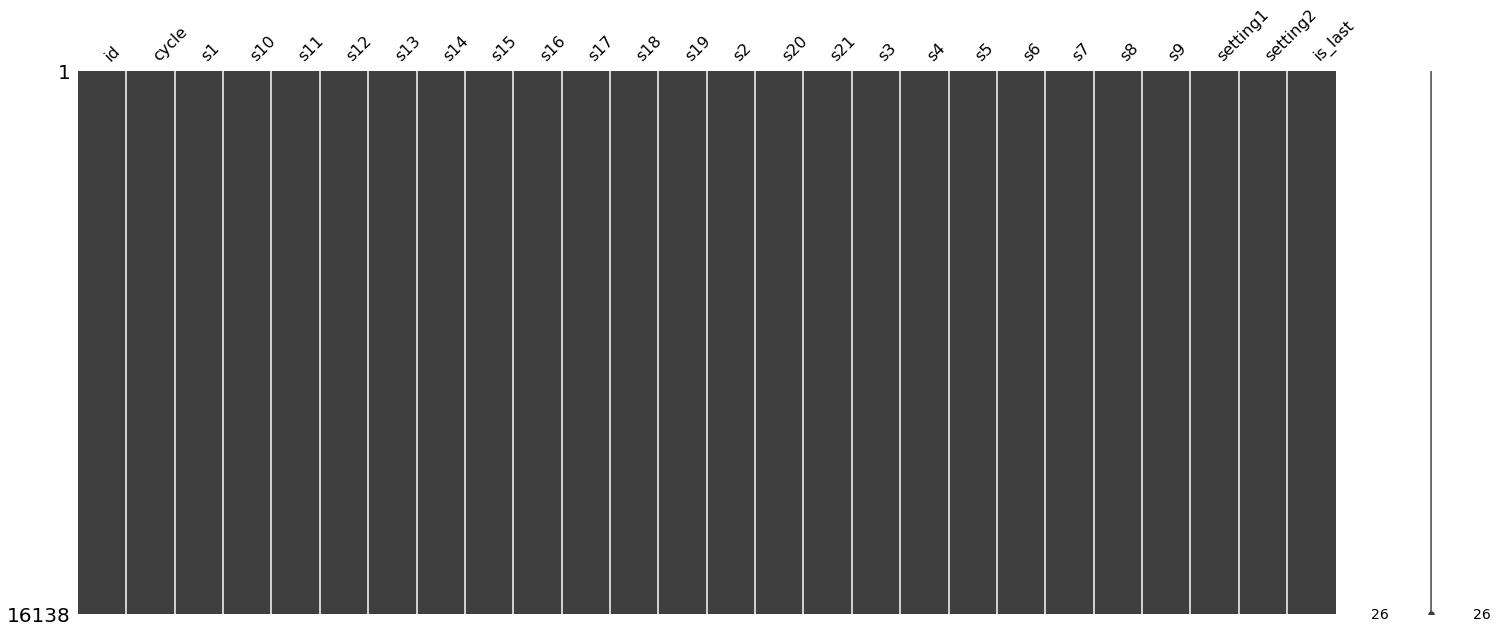

In [7]:
# Пропуски не обнаружены
msno.matrix(train); # test

In [29]:
def plot_compare_distributions(train_df,
                               test_df,
                               features,
                               r_size=6,
                               c_size=3
                              ):
    
    """Визуализация распределений признаков для тренеровочных и тестовых данных"""

    fig = plt.figure(figsize=(16,20))

    for num, feature in enumerate(features):
        try:
            train_data, test_data = train_df[feature].copy(), test_df[feature].copy()
            ax = fig.add_subplot(6, 3, num+1)
            sns.kdeplot(train_data, ax=ax, color="blue", label="train")
            sns.kdeplot(test_data, ax=ax, color="green", label="test")

        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=ax, color="blue", label="train")
        ax.set_title(feature, fontsize=14)
        fig.tight_layout()

In [58]:
# ftmp = 's1'
# train[ftmp].min(), train[ftmp].max(), test[ftmp].min(), test[ftmp].max()

(518.67, 518.67, 518.67, 518.67)

Полезно сравнить распределения для обучающей и тестовой выборки. Наблюдается схожесть распределений, что позволяет сделать вывод, что данные пришли их одного распределения, можно использовать статистические модели для этих распределений и ожидать их адекватное поведение

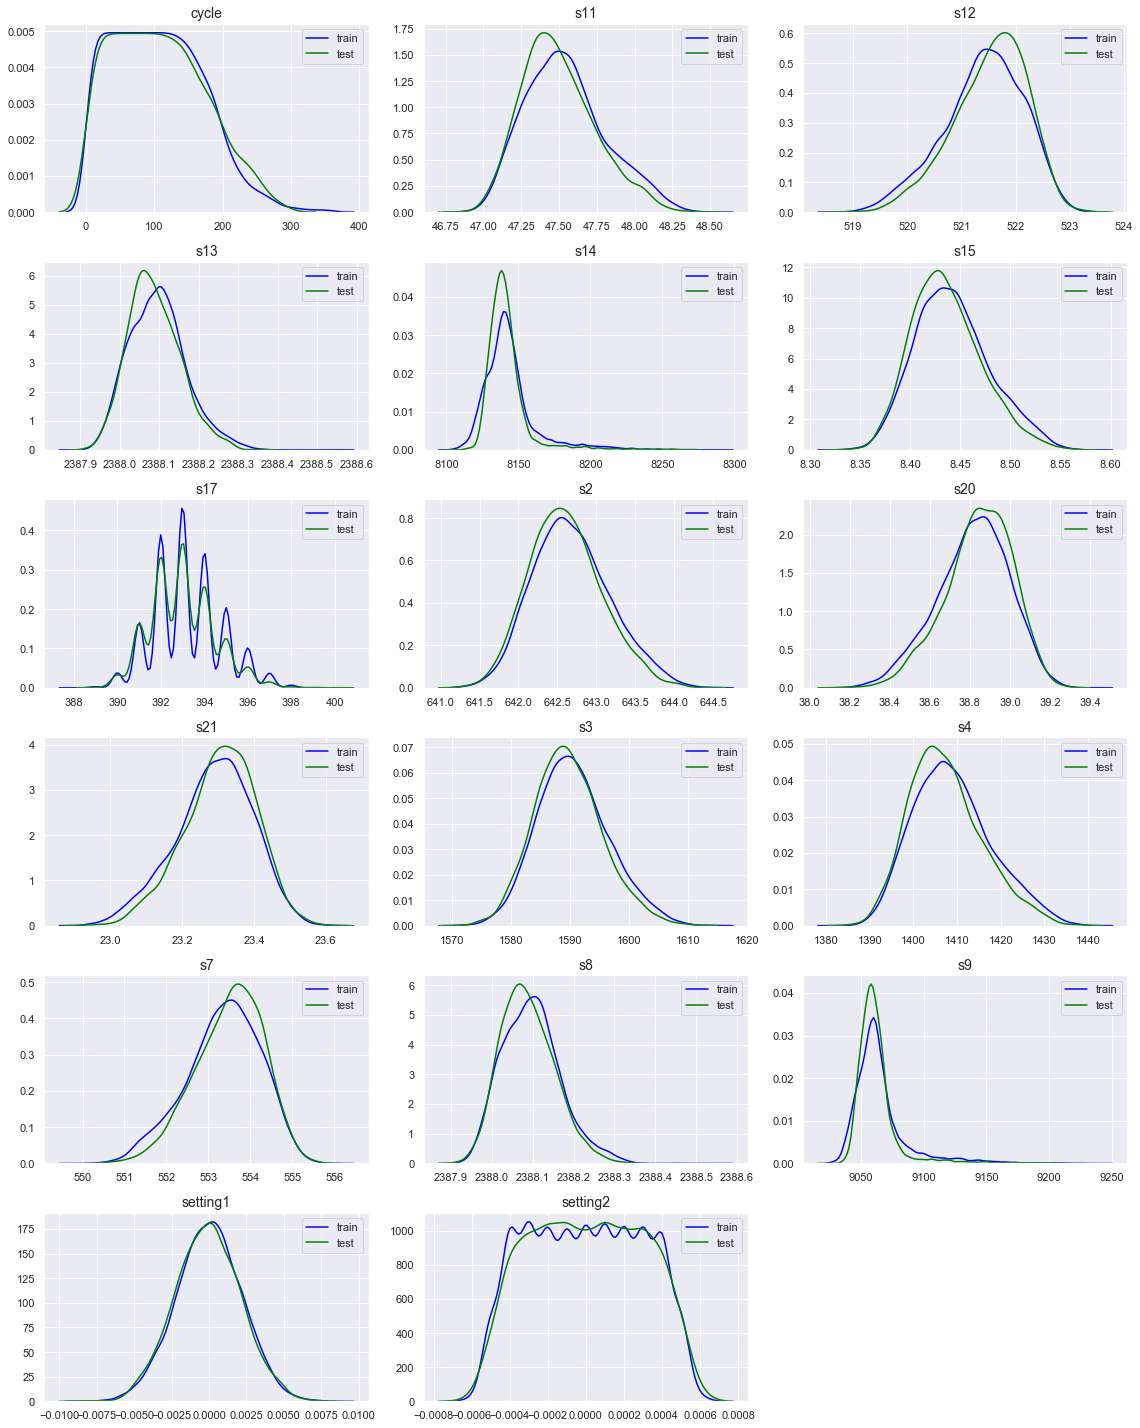

In [60]:
# признаки - константы
outlier_feats = ['s1', 's10', 's16', 's18', 's19', 's5', 's6']
# анализируемые признаки
compare_plot_target_feats = ['cycle', 's11', 's12', 's13', 's14', 's15',
                's17' , 's2', 's20', 's21', 's3', 's4',
                's7', 's8', 's9', 'setting1', 'setting2']

plot_compare_distributions(train, test, features=compare_plot_target_feats)

Оценка смещения (skew) и сосредоточения (kurtosis) данных относительно центра. В целом, перекос соблюдается относительно train и test. Можно выделить 2 признака: `s9` и `s14`, для которых модель может работать по-разному для train и test данных (т.е. возможно переобучение)

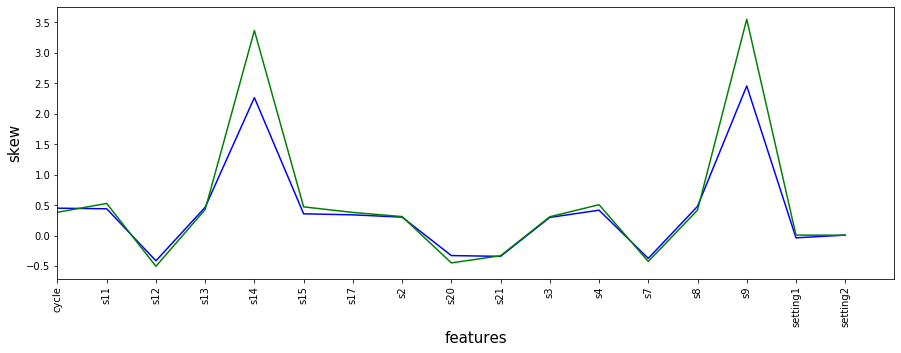

In [15]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train[compare_plot_target_feats].skew(), test[compare_plot_target_feats].skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

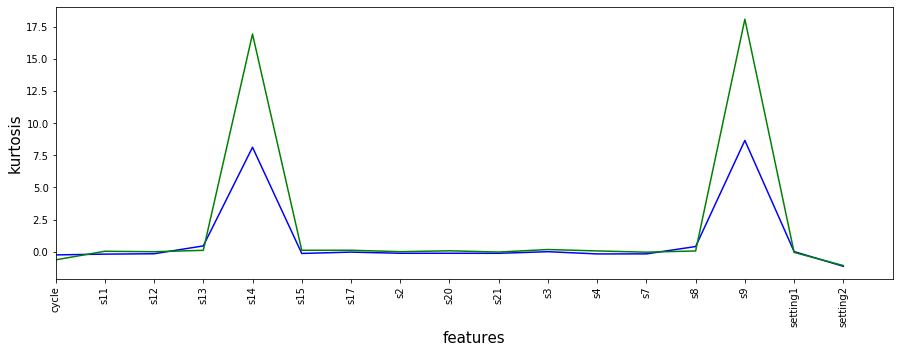

In [16]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train[compare_plot_target_feats].kurtosis(), test[compare_plot_target_feats].kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

Совпадение распределений на выборке для обучения и для тестирования - одна из ключевых коцепций статистического обучения. Обучая модель на некоторых данных, мы принимаем гипотезу о том, что модель должна работать на таких же данных. В качестве формального критерия используем один из базовых тестов - тест Колмогорова-Смирнова (при p-value < 0.05 - можно принять, что отличие между распределениями признаков незначительны) 

(более приемлемым вариантом для этой задачи будет расчет [PSI - population stability index](https://wiki.loginom.ru/articles/stability-index.html))

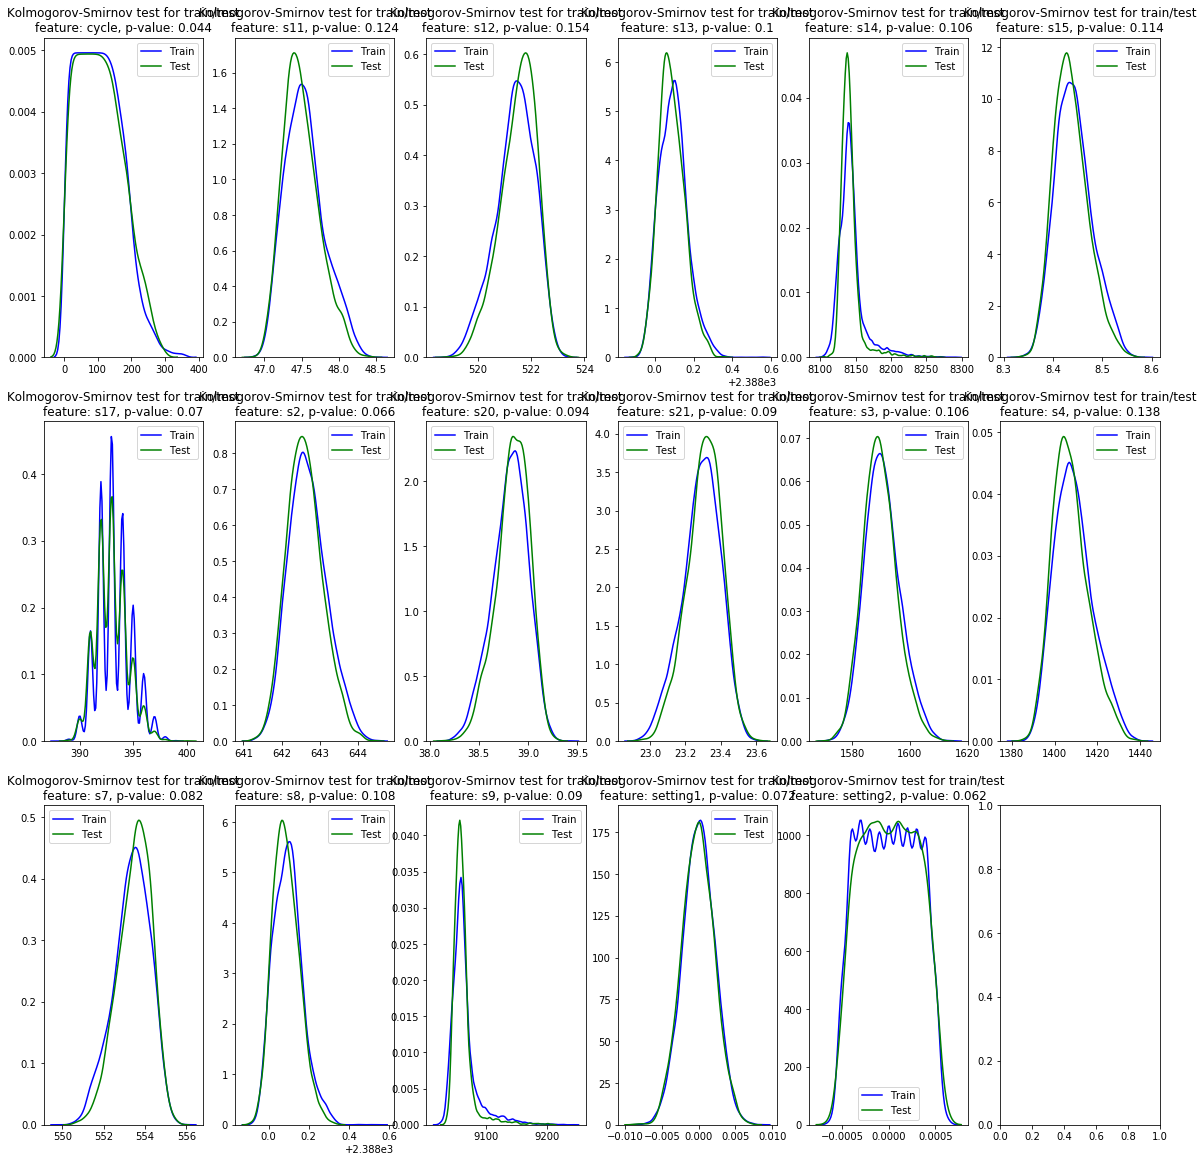

In [26]:
statistics_array = []
fig, axes = plt.subplots(3, 6, figsize=(20, 20))

for num, feature in enumerate(compare_plot_target_feats):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//6, num%6], color="Blue", label="Train")
    sns.kdeplot(test[feature], ax=axes[num//6, num%6], color="Green", label="Test")

    axes[num//6, num%6].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

#### Оценка линейной зависимости между признаками

In [66]:
train.columns

Index(['id', 'cycle', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7',
       's8', 's9', 'setting1', 'setting2', 'is_last'],
      dtype='object')

In [18]:
corr_feats = ['cycle', 's11', 's12', 's13', 's14', 's15',
       's17', 's2', 's20', 's21', 's3', 's4', 's7',
       's8', 's9', 'setting1', 'setting2', 'is_last']
# numeric_feats = train.select_dtypes(include=[np.number]).columns

correlation = train[corr_feats].corr()
corr_with_target = correlation['is_last'].sort_values(ascending = False)
corr_with_target[:10]

is_last    1.000000
s4         0.174068
s11        0.165557
s15        0.155746
s13        0.154713
s17        0.153124
s8         0.149836
s2         0.148068
s3         0.135673
s9         0.110951
Name: is_last, dtype: float64

На коррелограммах выражено отсутствие выраженной линейной связи между признаками и целевой переменной, а также высокая связь между группами признаков

Можно выделить 3 группы признаков: 
- высокая прямая зависимость (>0.5): более половины признаков
- отрицательная зависимость: `s12, s20, s21, s7` - в рамках зависимости от номера цикла можно предположить, что эти параметры отражают деградацию мотора и/или замедления технологических процессов
- зависимость, близкая к 0. Интересная особенность, что тех.параметры (`setting1, setting2`) линейно не связаны с измерениями приборов

Имеет смысл обучать нелинейные модели и оценивать важность признаков для конкретной модели

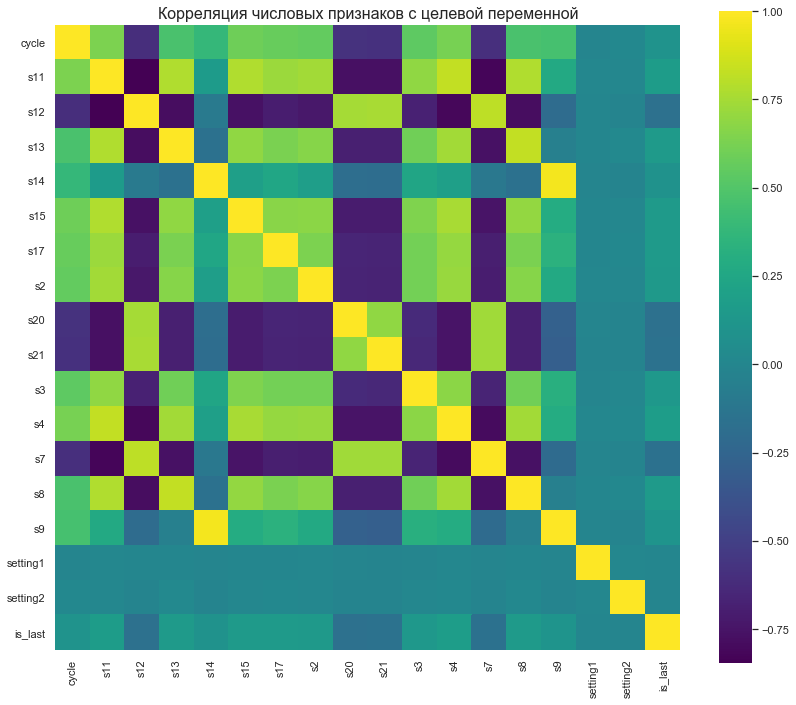

In [69]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Корреляция числовых признаков с целевой переменной", y=1, size=16)
sns.heatmap(correlation, square=True, cmap="viridis");

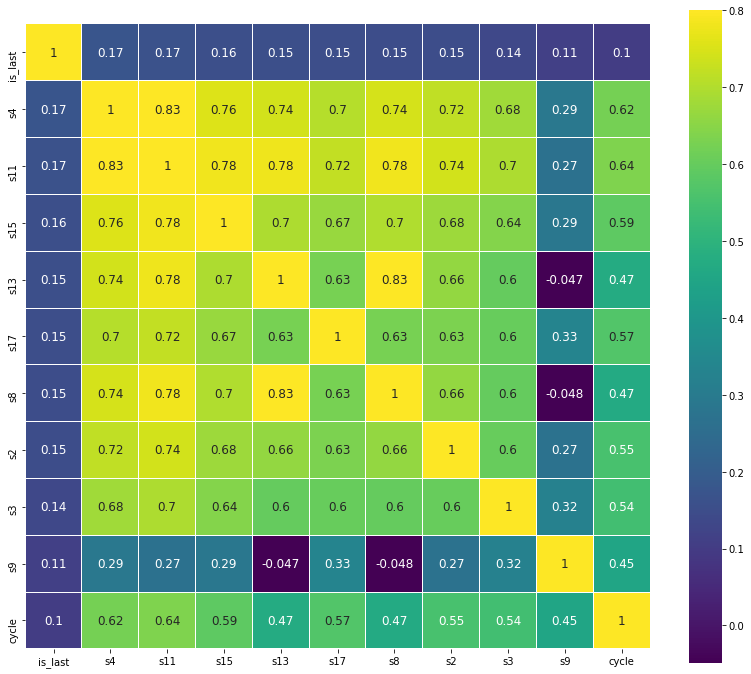

In [20]:
k = 11
cols = correlation.nlargest(k, "is_last")["is_last"].index
cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
);

PairPlot дает дополнительное представление о характере связи между признаками
На графиках ниже можно выделить признаки, в которых можно достаточно четко выделить границы последних циклов работы оборудования, т.е. наличие некоторого предельного уровня, выше которого происходит поломка мотора

In [26]:
def plot_pairplot(columns: list,
                 data=train,
                 target='is_last'):
    """Визуализация попарных распределений признаков в разрезе целевой переменной"""
    
    sns.set()
    sns.pairplot(train[columns], height=3, kind="scatter",
                 diag_kind="kde", diag_kws={'bw':'1.0'}, hue='is_last')
    plt.show()

C:\Users\Nickel\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Nickel\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


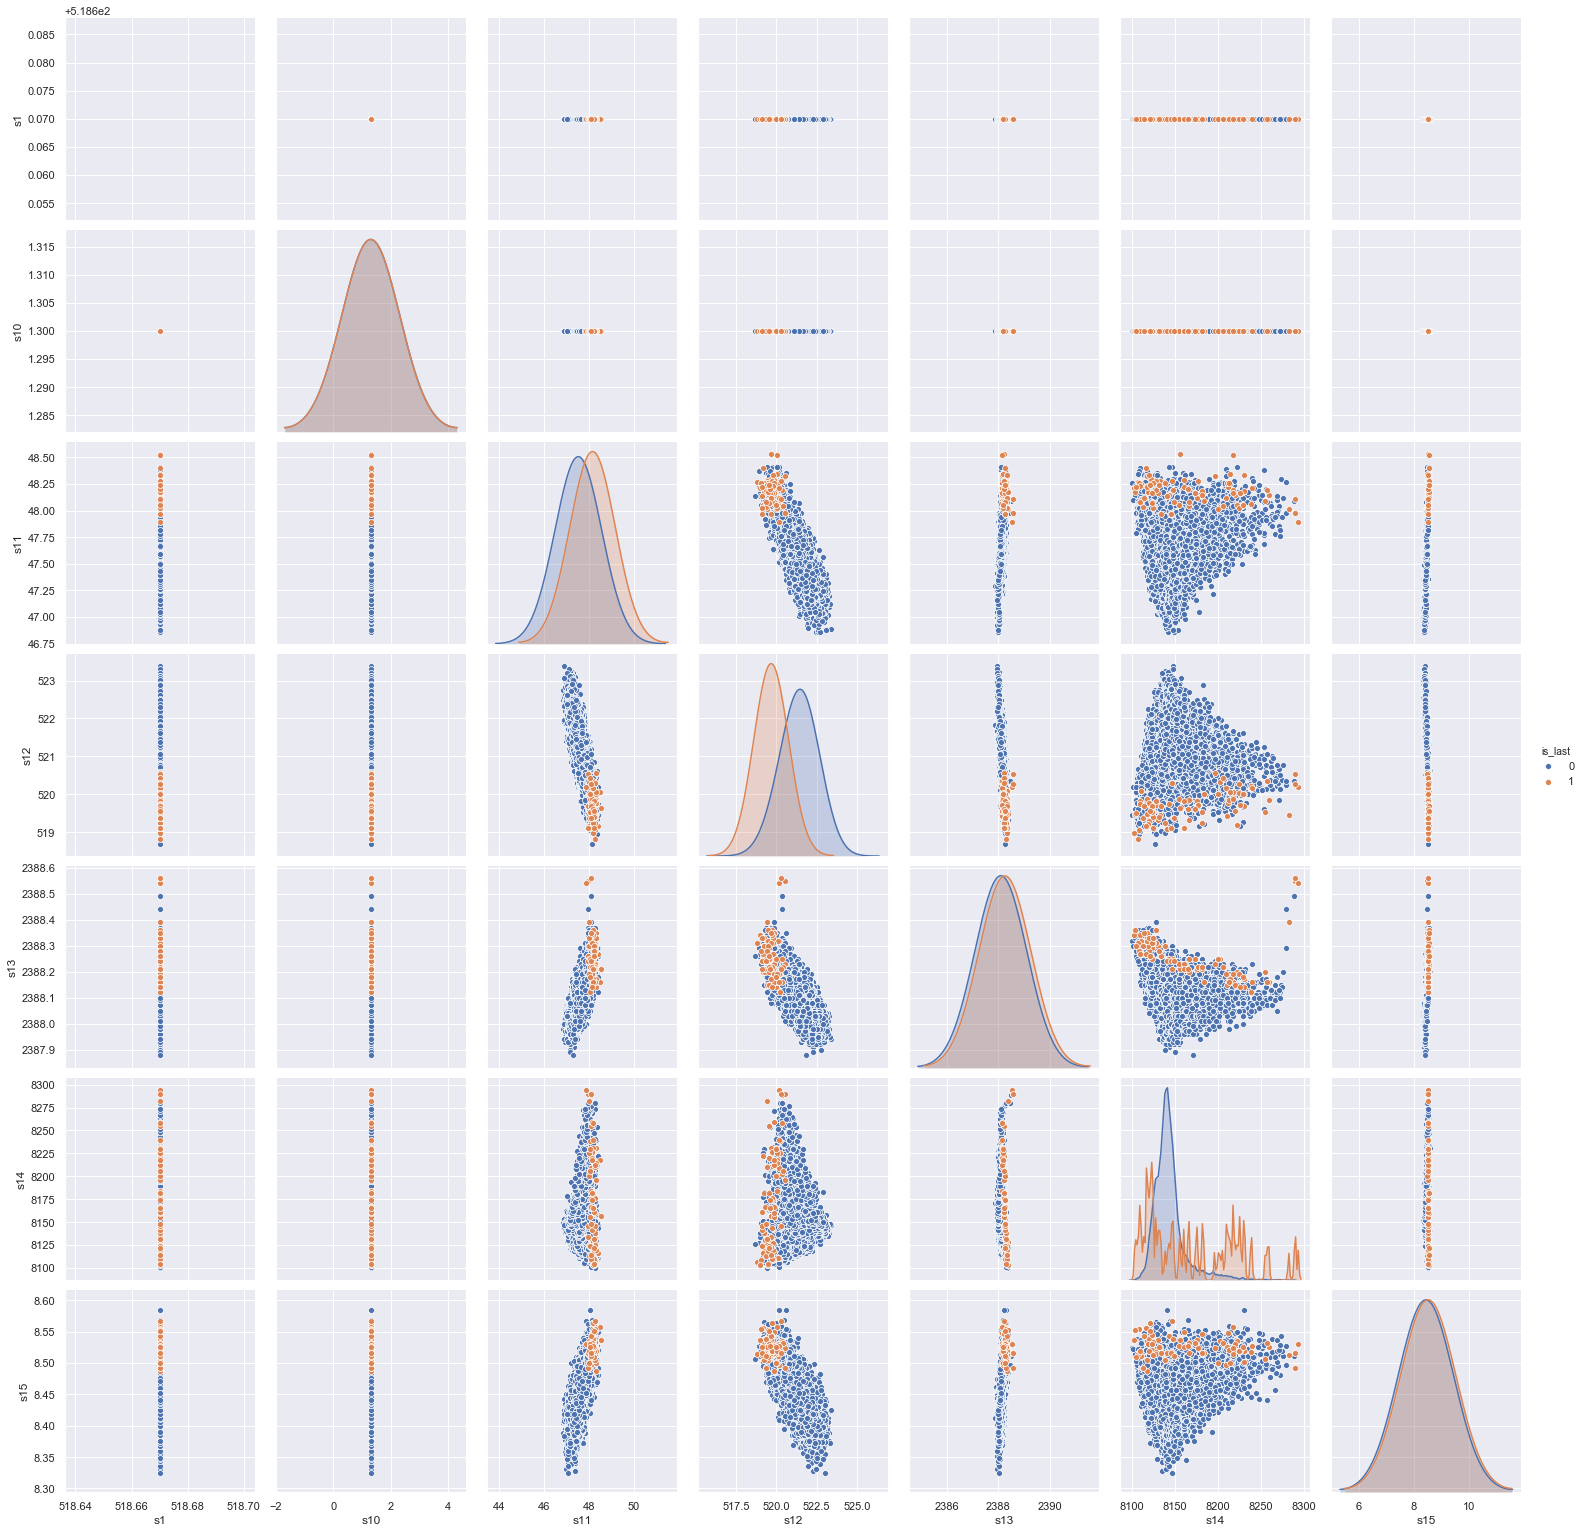

In [23]:
feat_set_1 = ['s1', 's10', 's11', 's12', 's13', 's14', 's15', 'is_last']
plot_pairplot(columns=feat_set_1)

C:\Users\Nickel\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Nickel\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Nickel\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Nickel\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


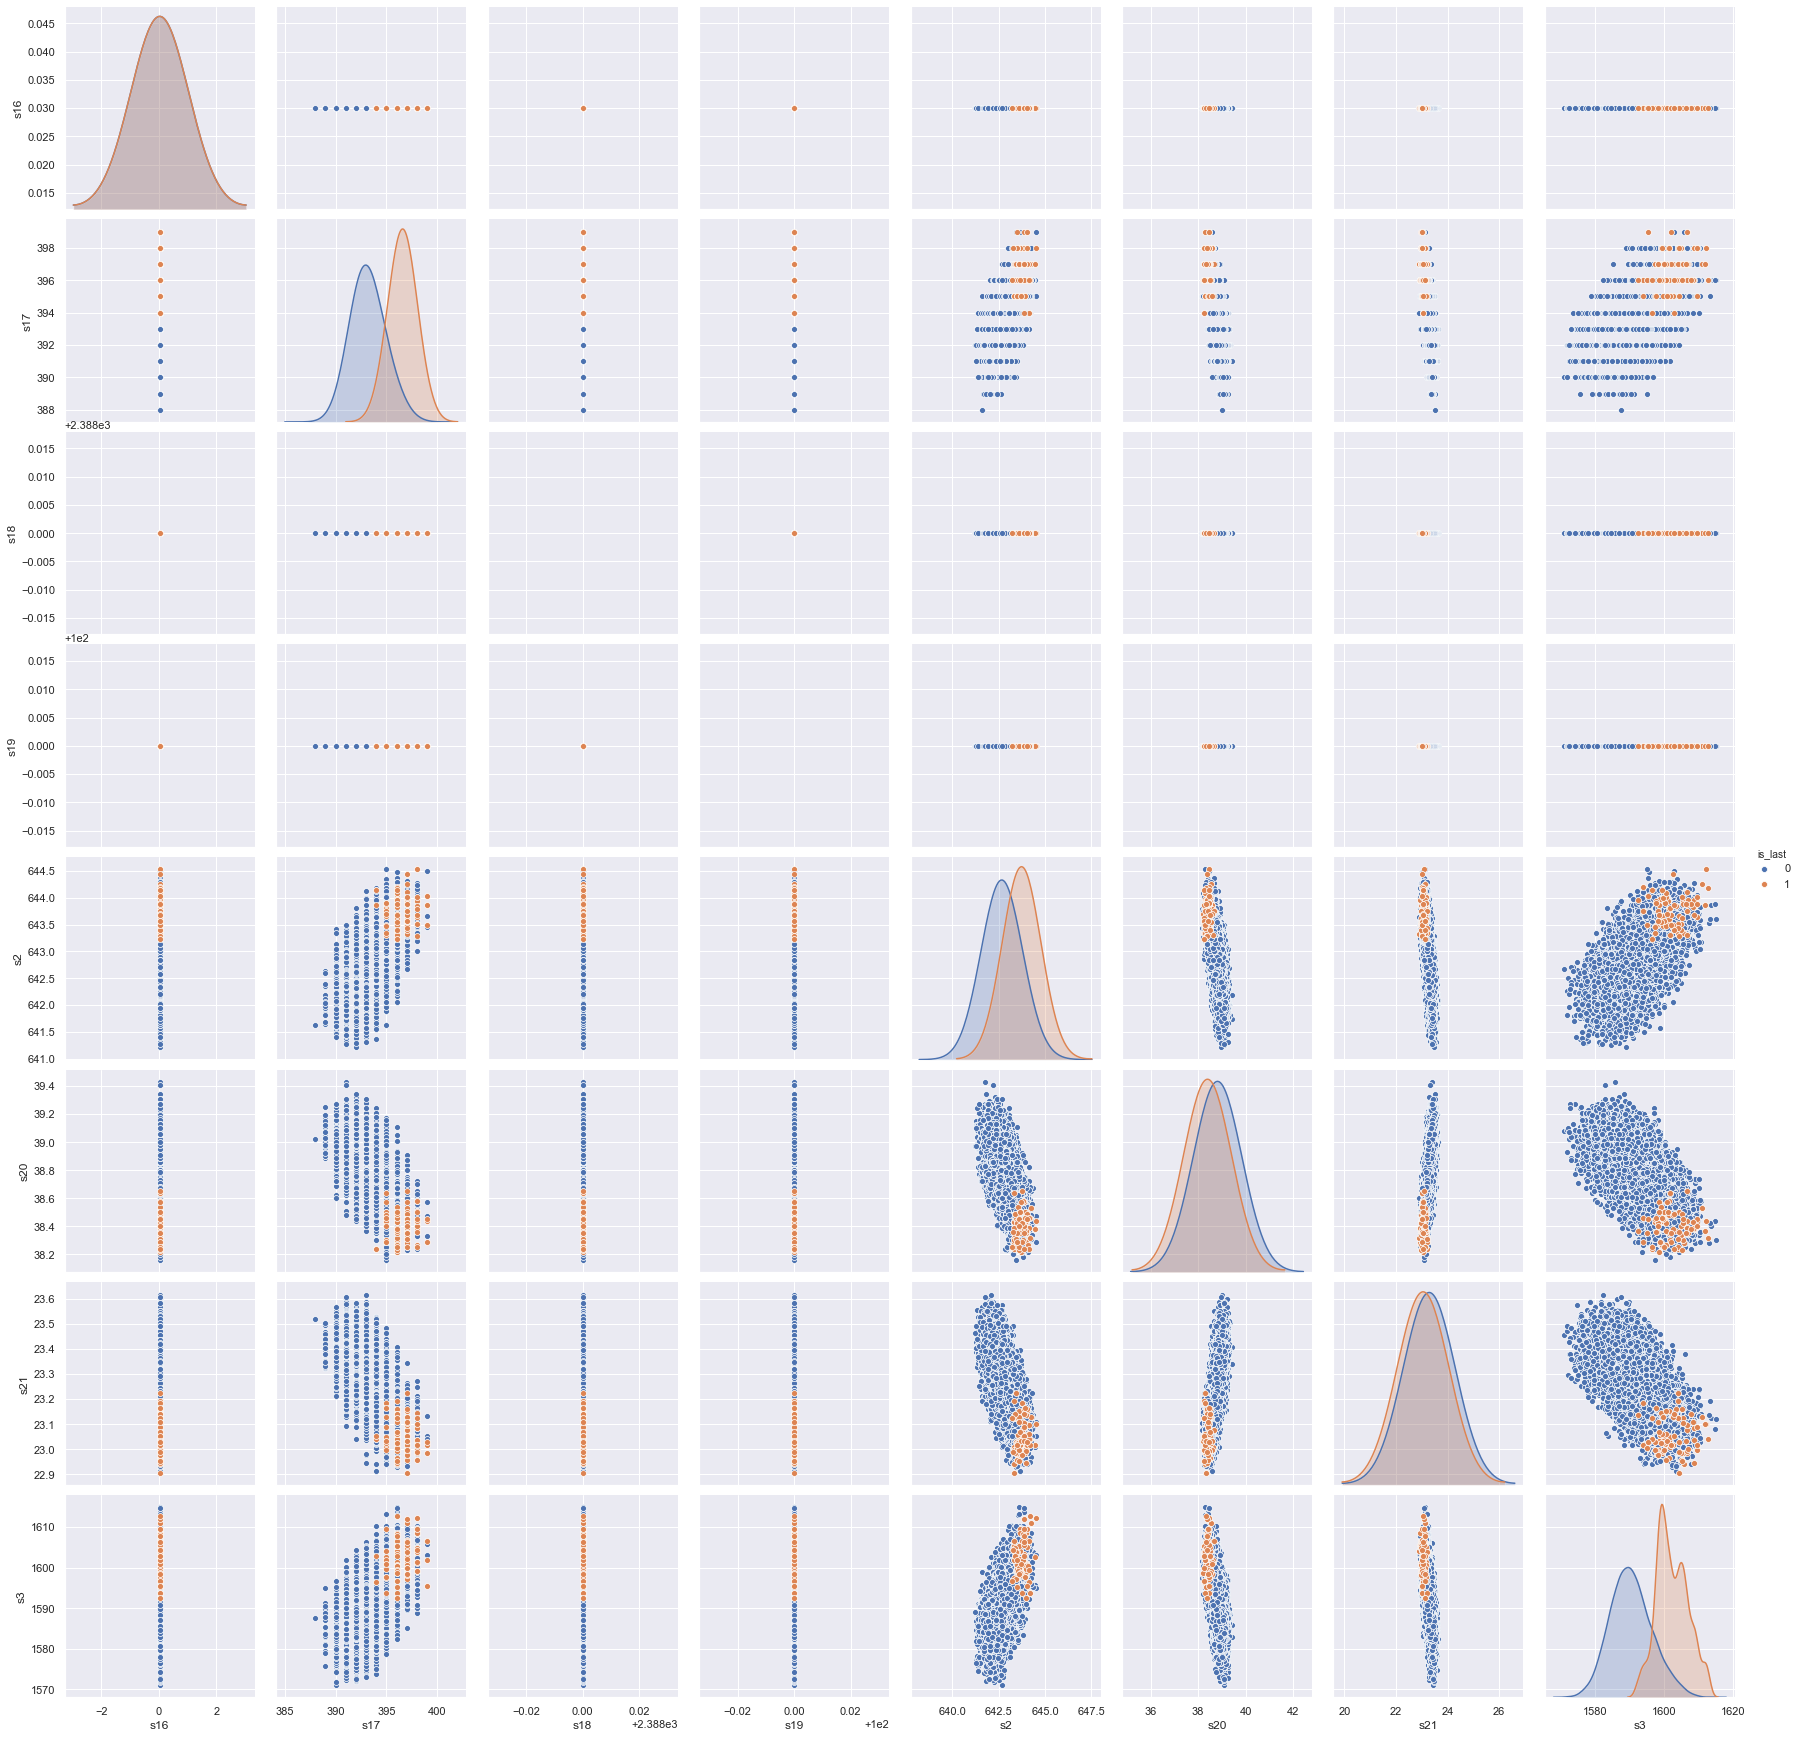

In [24]:
feat_set_2 = ['s16', 's17', 's18', 's19', 's2', 's20', 's21', 's3', 'is_last']
plot_pairplot(columns=feat_set_2)

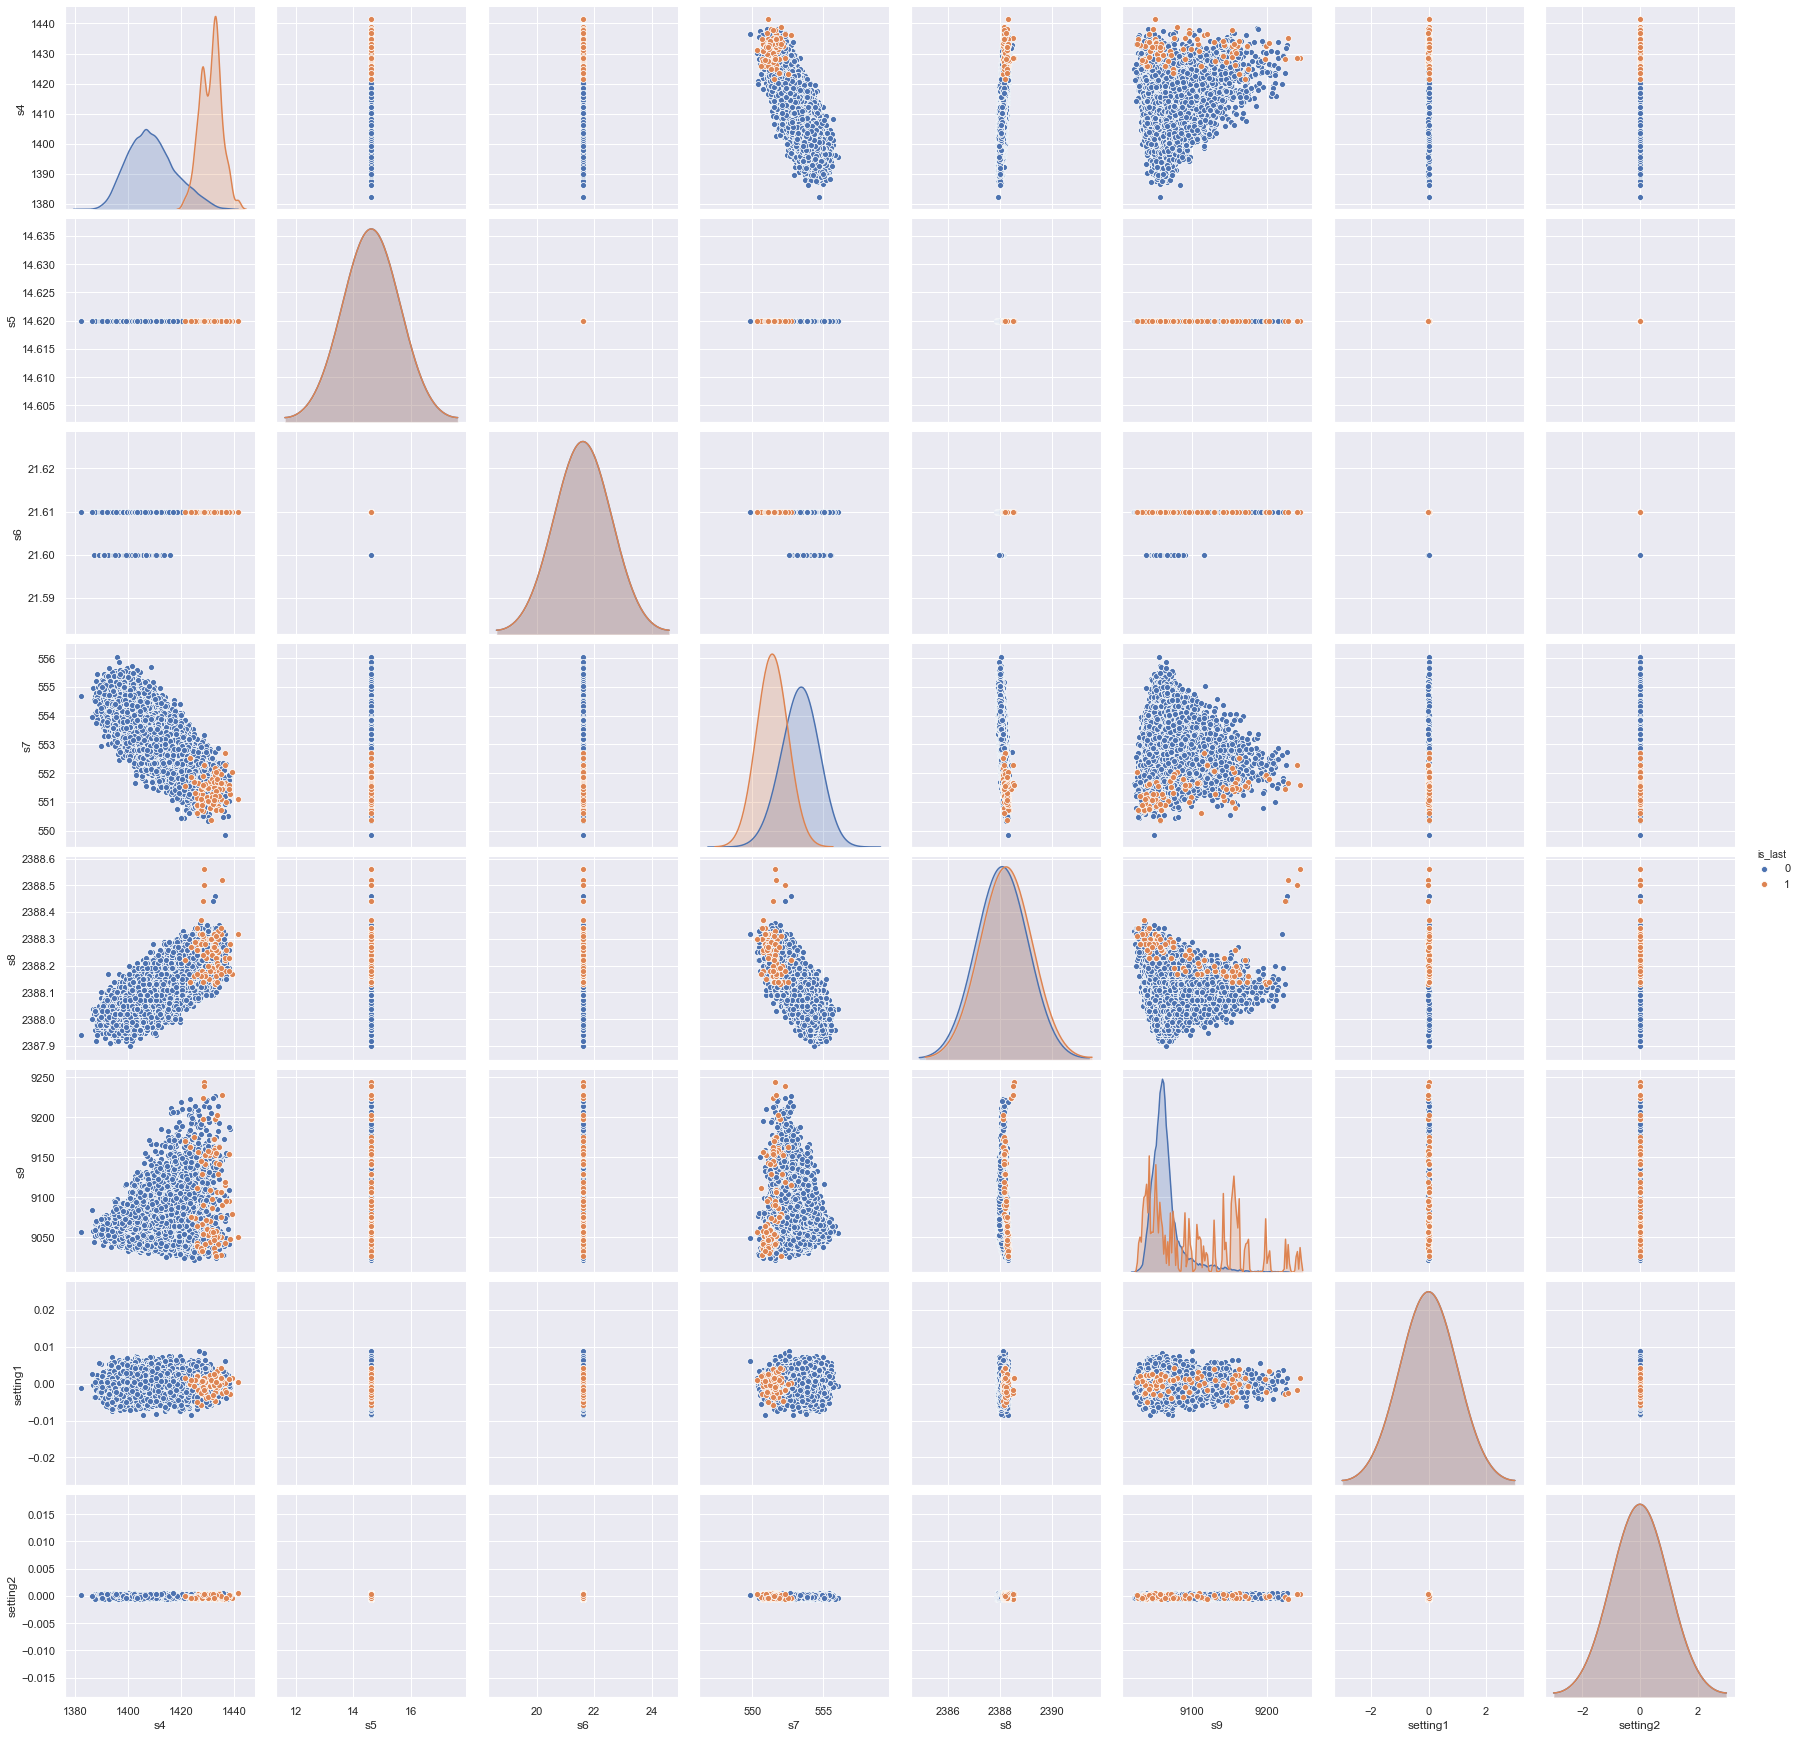

In [25]:
feat_set_3 = ['s4', 's5', 's6', 's7', 's8', 's9', 'setting1', 'setting2', 'is_last']
plot_pairplot(columns=feat_set_3)

Также полезно проанализировать распределение целевой переменной `is_last` в зависимости от значений признаков. Можно выделить ряд признаков - `s2, s3, s4, s7, s11, s12, s15` значения которых сильно различаются в зависимости от целевой переменной. Такие признаки можно использовать для определения критических областей функционирования оборудования.

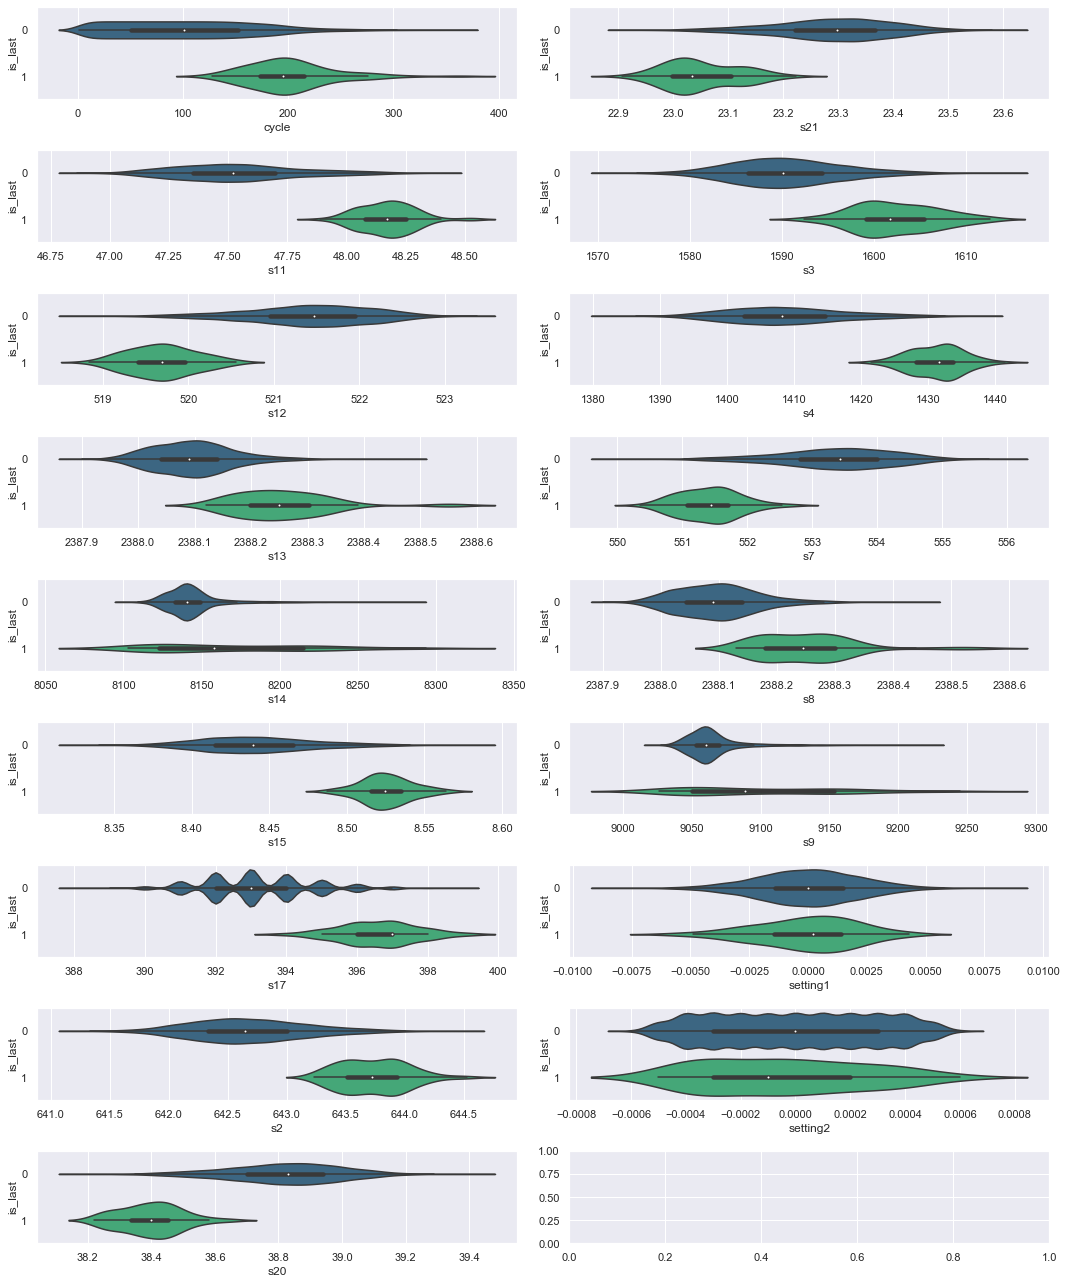

In [77]:
fig, axes = plt.subplots(9, 2, figsize=(15, 18))

for num, feature in enumerate(train[['cycle', 's11', 's12', 's13', 's14', 's15',
       's17', 's2', 's20', 's21', 's3', 's4', 's7',
       's8', 's9', 'setting1', 'setting2']]):
    sns.violinplot(y="is_last",
                   x=feature,
                   data=train[train['is_last'].isin([0, 1])],
                   orient="h",
                   ax=axes[num%9, num//9],
                   palette='viridis'
                  )
fig.tight_layout()

**Оценка изменения показателей по циклам**

Изменение параметров в зависимости от цикла для конкретного выбранного мотора

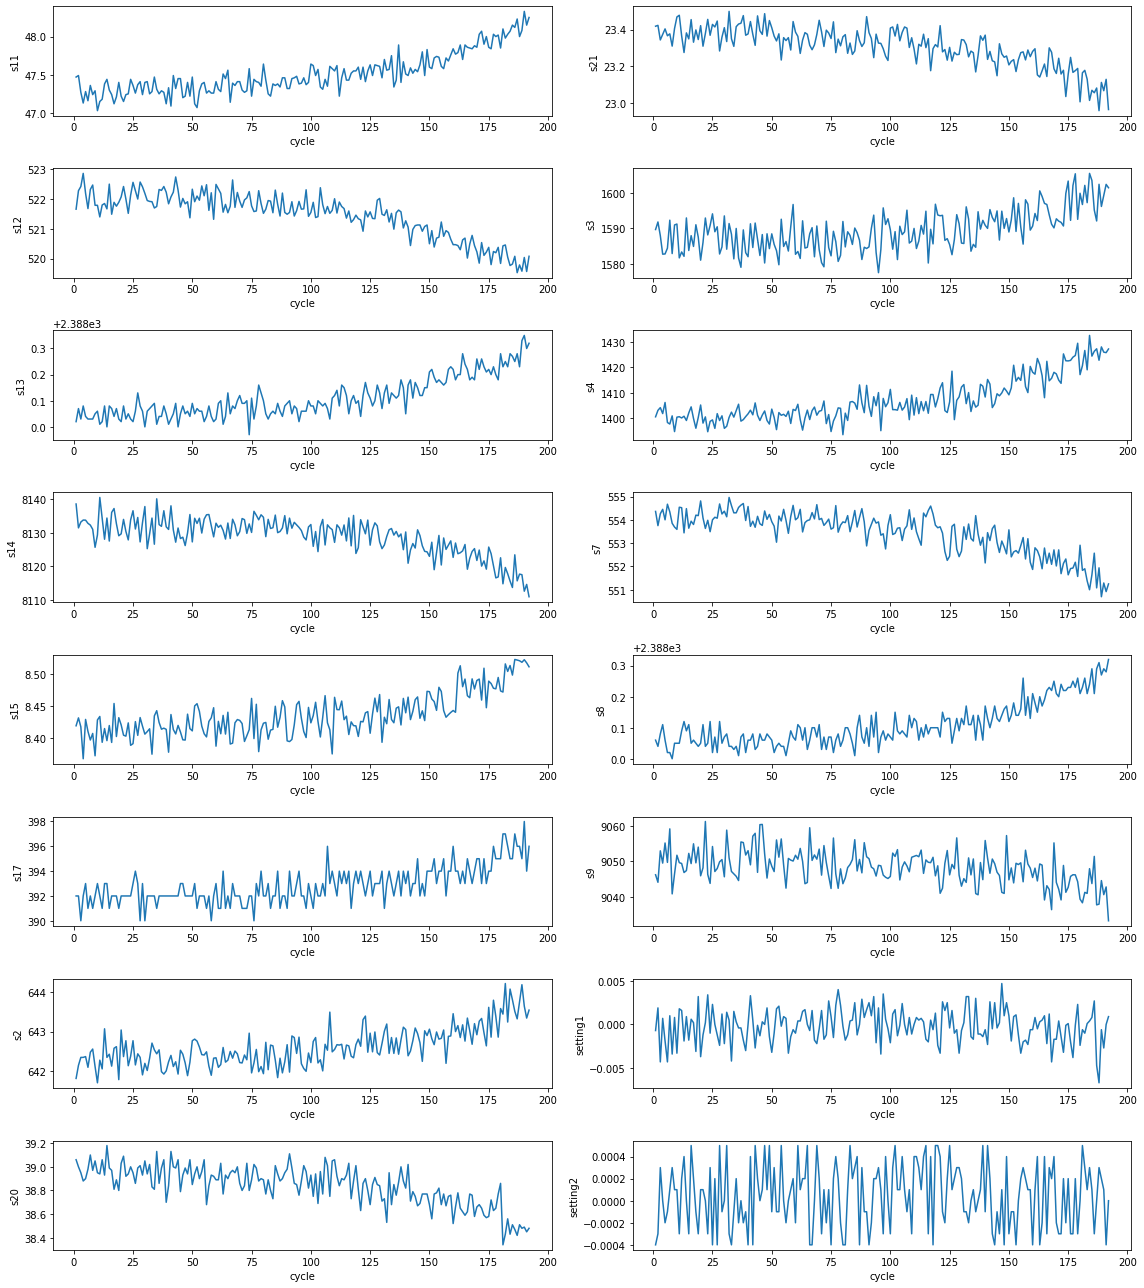

In [42]:
# Фильтрация по номеру мотора
engine_df = train.loc[train['id']=='Engine_1']

feats = ['s11', 's12', 's13', 's14', 's15', 's17', 's2', 's20',
         's21', 's3', 's4', 's7', 's8', 's9', 'setting1', 'setting2']
fig, axes = plt.subplots(8, 2, figsize=(16, 18))
for num, feature in enumerate(feats):
    sns.lineplot(x=engine_df['cycle'],
                 y=engine_df[feature],
                 ax=axes[num%8, num//8],
                 palette='viridis'
                )
    
fig.tight_layout();

Изменение параметров в зависимости от цикла для всех моторов в `train`

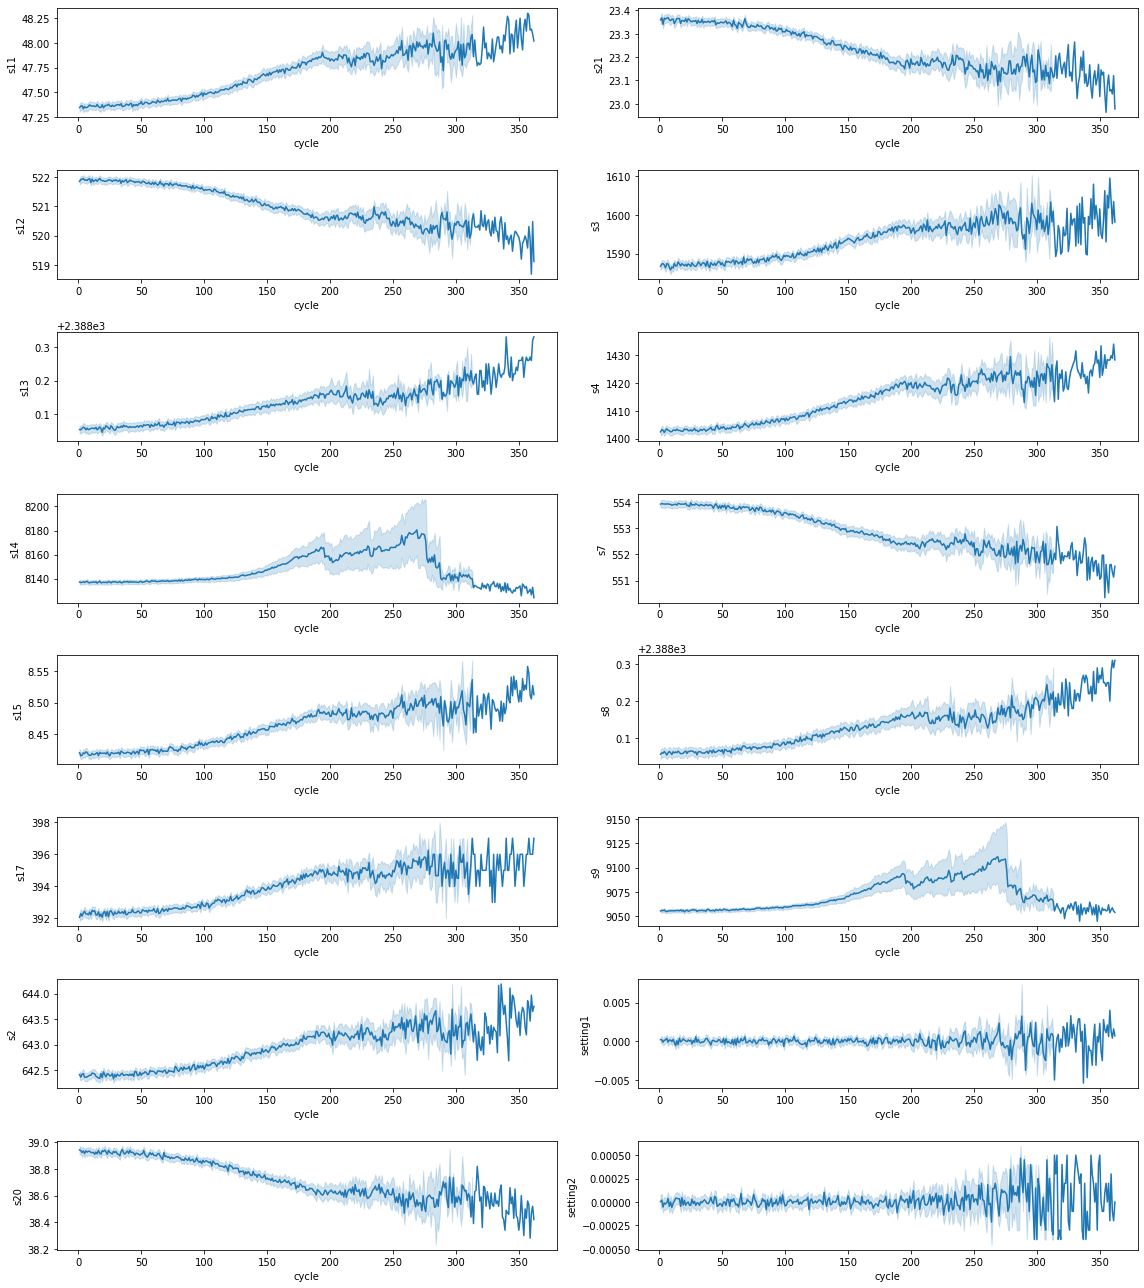

In [43]:
feats = ['s11', 's12', 's13', 's14', 's15', 's17', 's2', 's20',
         's21', 's3', 's4', 's7', 's8', 's9', 'setting1', 'setting2']
fig, axes = plt.subplots(8, 2, figsize=(16, 18))
for num, feature in enumerate(feats):
    sns.lineplot(x=train['cycle'],
                 y=train[feature],
                 ax=axes[num%8, num//8],
                 palette='viridis'
                )
    
fig.tight_layout();

Изменение параметров в зависимости от цикла для всех моторов в `test`

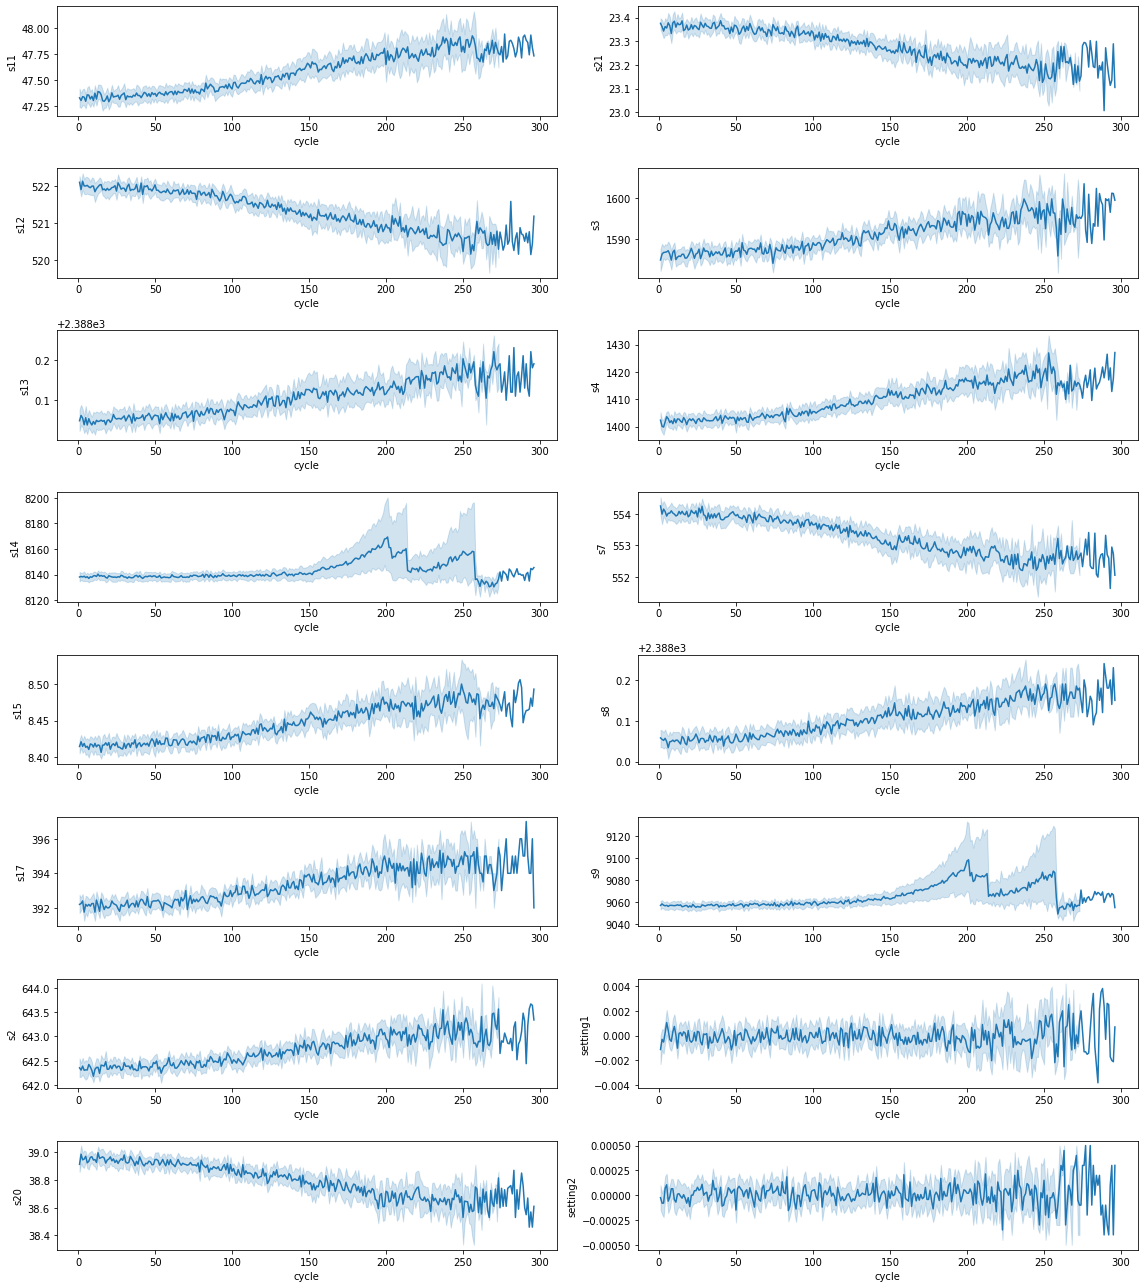

In [45]:
feats = ['s11', 's12', 's13', 's14', 's15', 's17', 's2', 's20',
         's21', 's3', 's4', 's7', 's8', 's9', 'setting1', 'setting2']
fig, axes = plt.subplots(8, 2, figsize=(16, 18))
for num, feature in enumerate(feats):
    sns.lineplot(x=test['cycle'],
                 y=test[feature],
                 ax=axes[num%8, num//8],
                 palette='viridis'
                )
    
fig.tight_layout();

Оценка диапазонов критических значений датчиков, в при которых констатирована поломка 

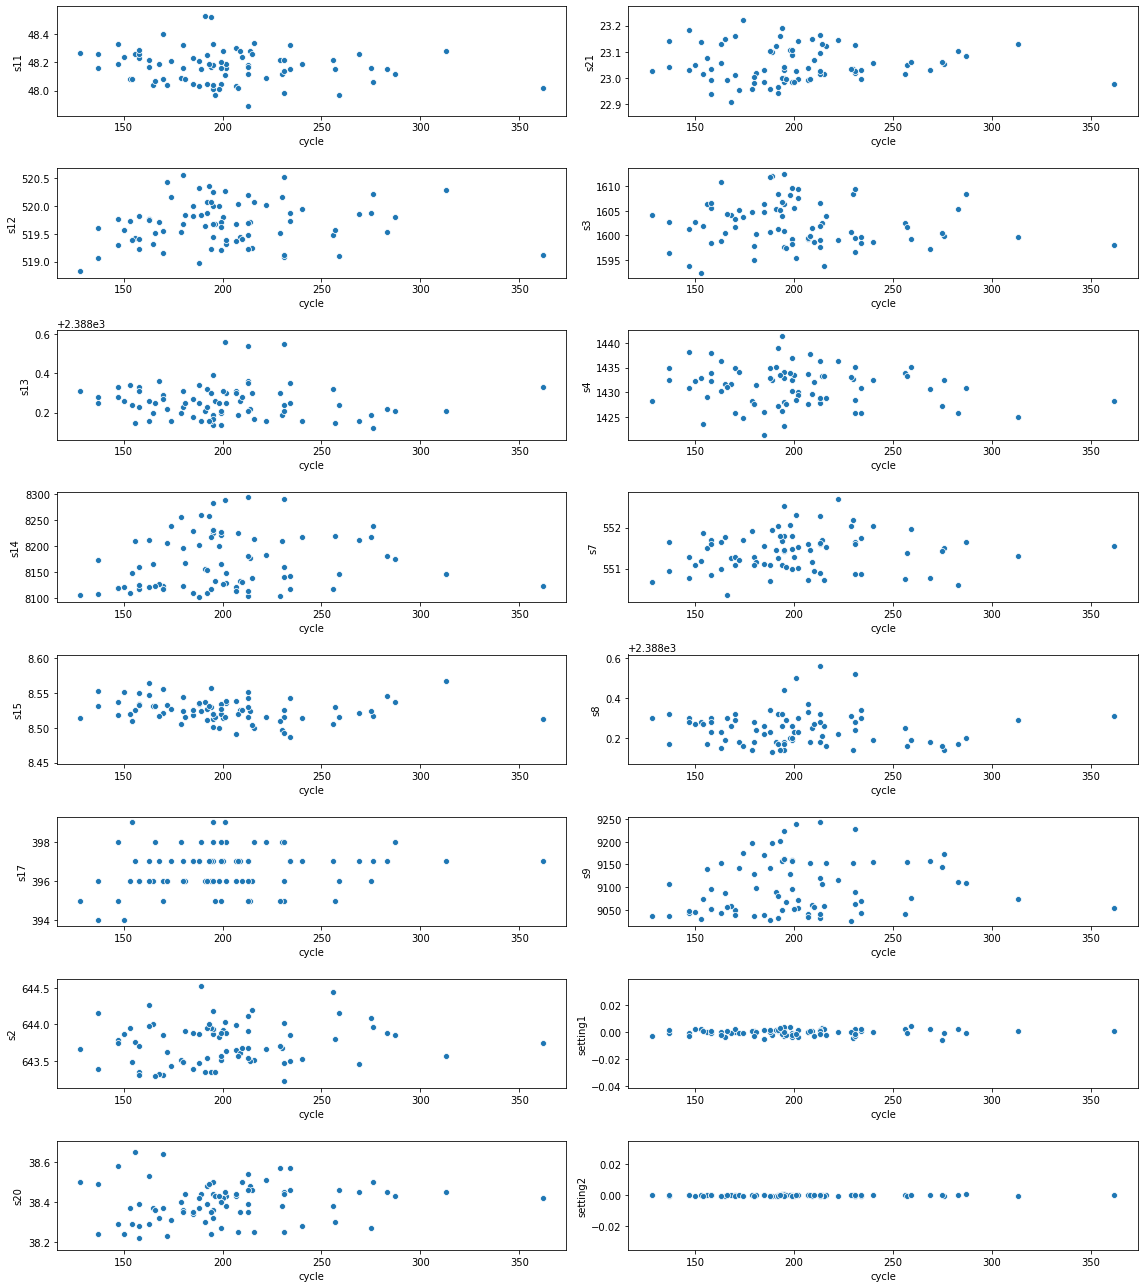

In [47]:
# Фильтрация по последним циклам
last_cycle_df = train.loc[train['is_last']==1]
feats = ['s11', 's12', 's13', 's14', 's15', 's17', 's2', 's20',
         's21', 's3', 's4', 's7', 's8', 's9', 'setting1', 'setting2']
fig, axes = plt.subplots(8, 2, figsize=(16, 18))
for num, feature in enumerate(feats):
    sns.scatterplot(x=last_cycle_df['cycle'],
                    y=last_cycle_df[feature],
                    ax=axes[num%8, num//8],
                    palette='viridis'
                   )
    
fig.tight_layout();

## Гипотеза. Бустинговая модель, детектирование порога вероятностей в критической области 
Рассмотренные в разделе EDA признаки позволяют построить модель классификации без привязки к хронологической последовательности циклов, т.к. целевая переменная по большей части зависит от показаний приборов и основная задача состоит в определении вхождения в критическую область комбинации параметров, хорошим результатом будет детектирование роста вероятности поломки при приближении к критическим значениям. Так можно настроить вероятность предсказаний, при которой мотор входит в критическую область поломки.


In [7]:
class DataSplitter(BaseEstimator, TransformerMixin):
    """Класс для тестирования различных сплитов"""
    def __init__(self, split_type='simple'):
        assert split_type in ['simple'], "Error. Wrong split type"
        self.split_type = split_type
        
    def simple_split_data(self, 
                          train: pd.DataFrame, 
                          test_size: float = 0.3):
        """Разбиение для Hold-out валидации с 2 сплитами"""
        X = train.drop(['is_last', 'id'], axis=1)
        y = train['is_last']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, stratify=y)
        return X_train, X_val, y_train, y_val
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.DataFrame):
        if split_type == 'simple':
            X_train, X_val, y_train, y_val = self.simple_split_data(X)
        return X_train, X_val, y_train, y_val

In [138]:
pipeline = Pipeline([
    ('Dataset', EngineDataTransformer()),
    ('Preprocessor', PreprocessData()),
    ('Splitter', DataSplitter())
])

X_train, X_val, y_train, y_val = pipeline.fit_transform(train_path)

Reading test_engine/Data_80.csv: shape = 16138 rows, 25 cols


In [139]:
y_val.value_counts(normalize=True)

0    0.990172
1    0.009828
Name: is_last, dtype: float64

In [140]:
# Изменение весов классов
compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)

array([ 0.50496454, 50.85714286])

In [141]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "task_type": "GPU",
    "max_bin": 20,
    "verbose": 500,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42,
    'class_weights': [5, 50]
}

model = CatBoostClassifier(**cb_params)
model.fit(X_train, y_train)

0:	learn: 0.6609173	total: 57.9ms	remaining: 1m 55s
500:	learn: 0.0401489	total: 31.5s	remaining: 1m 34s
1000:	learn: 0.0377735	total: 57.1s	remaining: 57s
1500:	learn: 0.0315183	total: 1m 23s	remaining: 27.6s
1999:	learn: 0.0288558	total: 1m 47s	remaining: 0us


In [143]:
# С небольшим подбором параметров качестов достигает 99%
val_score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
print(f'Roc auc Hold-out 2 val_score: {val_score}')

Roc auc Hold-out 2 val_score: 0.9815791287565482


In [144]:
def plot_roc_curve(model, X_val, y_val, xlim=[0.0, 0.02]):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(4, 4))
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1], pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim(xlim)
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

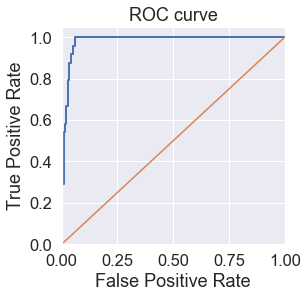

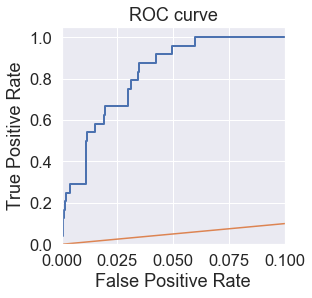

In [145]:
plot_roc_curve(model, X_val, y_val, xlim=[0.0, 1.0])
plot_roc_curve(model, X_val, y_val, xlim=[0.0, 0.1])

В данном примере была использована проста балансировка весов класса, однако дисбаланс классов продолжает вносить довольно ощутимое влияние на прогноз (вариант, можно попробовать технику upsampling target, например, ADASYN из imblearn.over_sampling). 

Shap анализ показывает вклад признаков в формирование прогнозов модели.
- для всего датасета основной вклад в результат вносит 7 признаков, на положительный прогноз влияет, в среднем, 4 признака

In [146]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


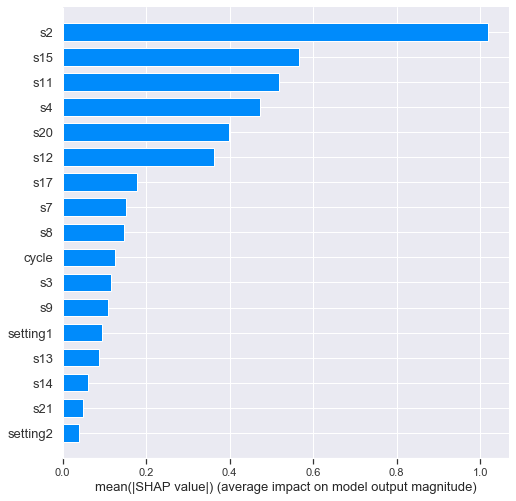

In [147]:
shap.summary_plot(shap_values, X_val, plot_type='bar')

Интерпретация поведения модели для значения с наибольшей вероятностью
- видно, что в детектировании положительной метки участвуют признаки `s2, s4, s11, s20` 

In [148]:
y_pred = pd.DataFrame({'prob': model.predict_proba(X_val)[:, 1]})
y_pred.sort_values(by='prob')

prob
635   6.496929e-07
703   6.966120e-07
1293  7.493299e-07
944   7.965730e-07
2378  7.974249e-07
...            ...
1925  9.272965e-01
1005  9.291523e-01
713   9.558558e-01
6     9.692526e-01
780   9.735490e-01

[2442 rows x 1 columns]

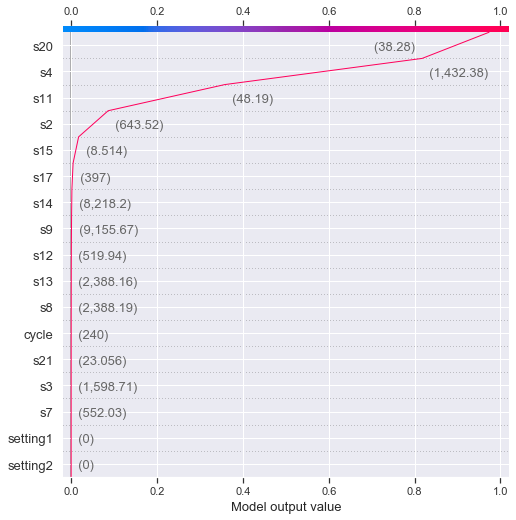

In [150]:
shap.decision_plot(explainer.expected_value, shap_values[780, :], X_val.iloc[780, :], link='logit')

Оценка предсказанной вероятности по моторам в зависимости от цикла

In [151]:
pred_eval_df = X_val.copy()
pred_eval_df['true'] = y_val
pred_eval_df['predict'] = model.predict_proba(pred_eval_df)[:, 1]
pred_eval_df['id'] = train['id'] # возвращаем номера моторов

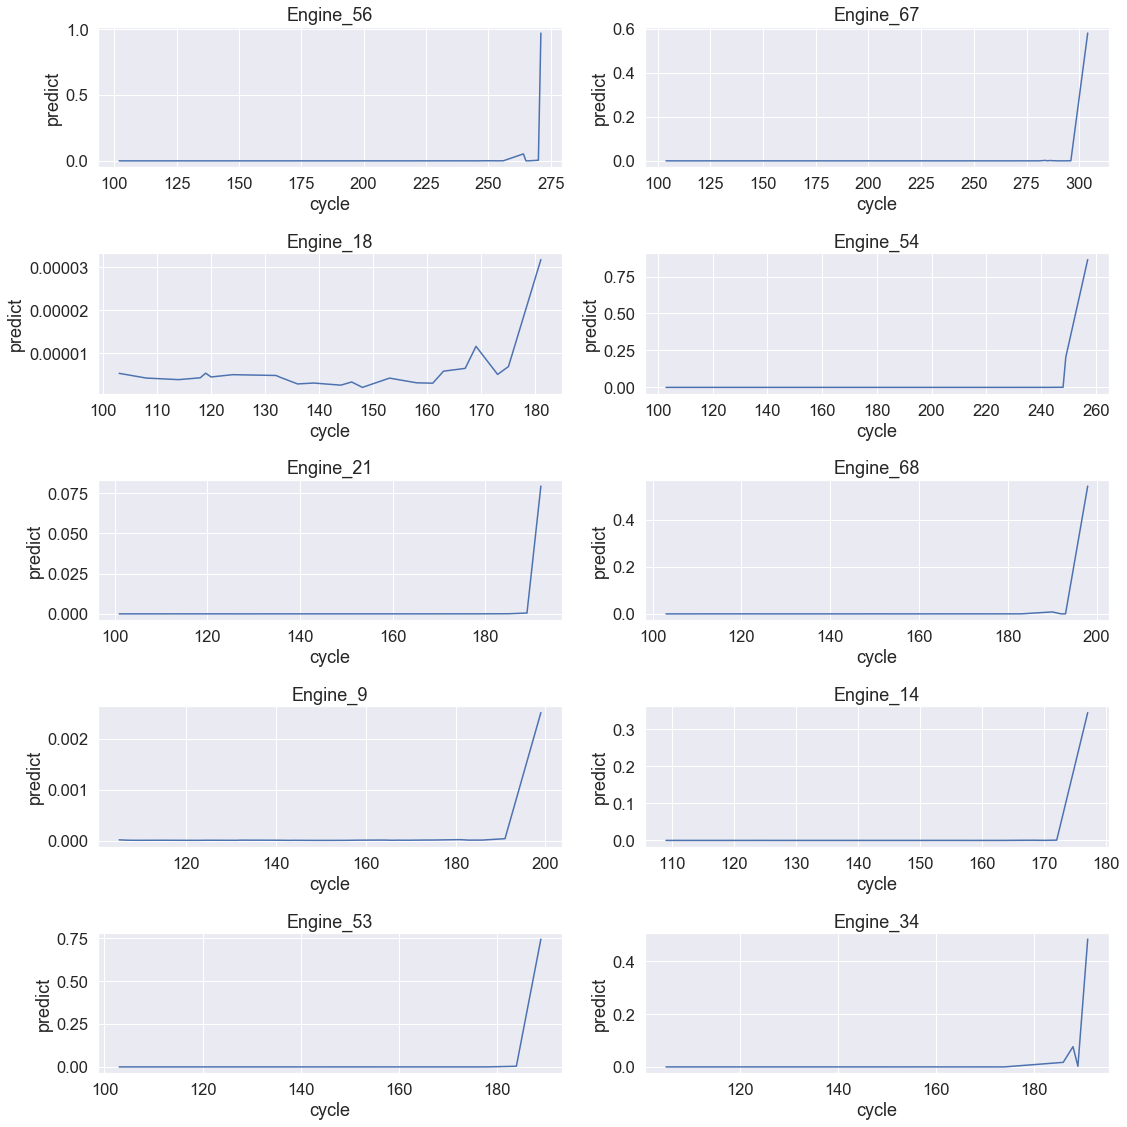

In [167]:
engine_ids = [engine_no for engine_no in pred_eval_df['id'].unique()[:10]]

fig, axes = plt.subplots(5, 2, figsize=(16, 16))
for num, engine in enumerate(engine_ids):
    X = pred_eval_df.loc[pred_eval_df['id']== engine]
    sns.lineplot(x=X['cycle'],
                 y=X['predict'],
                 ax=axes[num%5, num//5],
                 palette='viridis'
                ).set_title(engine)
    
fig.tight_layout();

Резюме и дальнейшее развитие:
- Получено интересное поведение модели: масштаб вероятностей предказания остается неоднородным, однако возможна стремительного роста вероятности предсказания (например, последовательный процентный рост на нескольких циклах, или скользящий средний рост) можно использовать для интерпретации финального цикла на тестовых данных.
- Вариант использования: последовательно подавать в модель данные с датчиков и фиксировать прогноз, после чего сравнивать прогноз нового цикла с предыдущим, после чего анализировать кривую роста и делать выводы о приближении финального цикла.
- Улучшить качество модели поможет балансировка целевой переменной (отличный кандидат - ADASYN)
- Стоит сделать провести детальный анализ временного ряда для экземпляра (мотора), построить основные статистики (1-n разности, скользящее среднее и т.д.) в разрезе каждого окна, что также поможет в фильтрации и выборе признаков.
- Оценку количества циклов до поломки можно проводить на основе предикта показаний ключевых параметров (в базовом случае, с помощью скользящей средней) с загрузкой этих данных в инференс модели.